In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta
import pickle
import requests
import numpy as np
from collections import defaultdict
%matplotlib inline
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["ytick.labelsize"] = 16
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["lines.linewidth"] = 3
plt.rcParams["figure.titlesize"] = 20

## Load data

In [3]:
df = pd.read_csv('data_preprocessed.csv', parse_dates=['Date'])

In [4]:
df.head()

,Unnamed: 0.1,Unnamed: 0,index,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,season,home_win,draw,away_win,winner,loser,month
0,0,0,0,D1,1993-08-07,bayernmunich,freiburg,3.0,1.0,H,NaN,NaN,NaN,1993-1994,1,0,0,bayernmunich,freiburg,8
1,1,1,8,D1,1993-08-07,werderbremen,stuttgart,5.0,1.0,H,NaN,NaN,NaN,1993-1994,1,0,0,werderbremen,stuttgart,8
2,2,2,7,D1,1993-08-07,wattenscheid,schalke04,3.0,0.0,H,NaN,NaN,NaN,1993-1994,1,0,0,wattenscheid,schalke04,8
3,3,3,6,D1,1993-08-07,m'gladbach,einfrankfurt,0.0,4.0,A,NaN,NaN,NaN,1993-1994,0,0,1,einfrankfurt,m'gladbach,8
4,4,4,1,D1,1993-08-07,dortmund,karlsruhe,2.0,1.0,H,NaN,NaN,NaN,1993-1994,1,0,0,dortmund,karlsruhe,8


In [5]:
# get a dictionary lookup with team id and the day before the team first played. this is the day that we will set the initial rating on

teams = pd.melt(df[['winner', 'loser', 'Date']], value_vars=['winner', 'loser'], id_vars='Date', value_name='team', var_name='status')
all_teams = teams.team.unique()

In [7]:
teams.head()

,Date,status,team
0,1993-08-07,winner,bayernmunich
1,1993-08-07,winner,werderbremen
2,1993-08-07,winner,wattenscheid
3,1993-08-07,winner,einfrankfurt
4,1993-08-07,winner,dortmund


## Elo

Win probability:

$$E_A = \frac{1}{1+10^{\frac{R_B-R_A}{n}}}$$

Update Rule:

$$R'_A = R_A + K(S_A-E_A)$$

Outcomes are:
- 1 for win
- 0 for loss
- 0.5 for draw

In [13]:
# write two functions: one that calculates the expected win probability and one that updates the rating
# remember you also need an initial rating value

def expected(a, b, n=400) -> float:
    return 1 / (1 + 10 ** ((b - a) / n))

def update(current, expected, outcome, k=10) -> float:
    return current + k * (outcome - expected)

Text(0.5, 1.0, 'Expected outcome of two teams for different values of n')

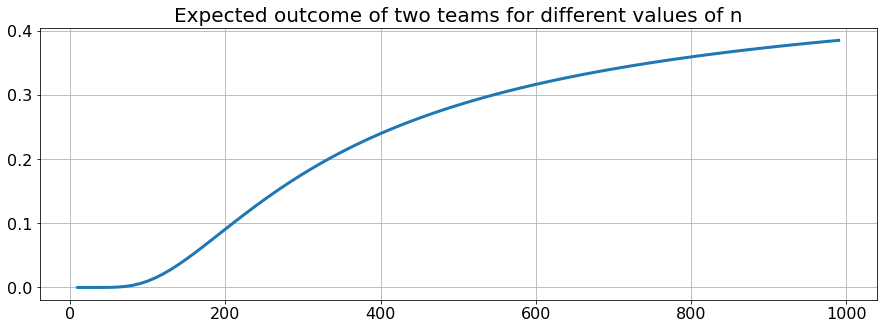

In [20]:
all_expected = []
for n in range(10, 1000, 10):
    all_expected.append(expected(1200, 1400, n))
plt.plot(range(10, 1000, 10), all_expected)
plt.title('Expected outcome of two teams for different values of n')

Text(0.5, 1.0, 'Change in rating based on K')

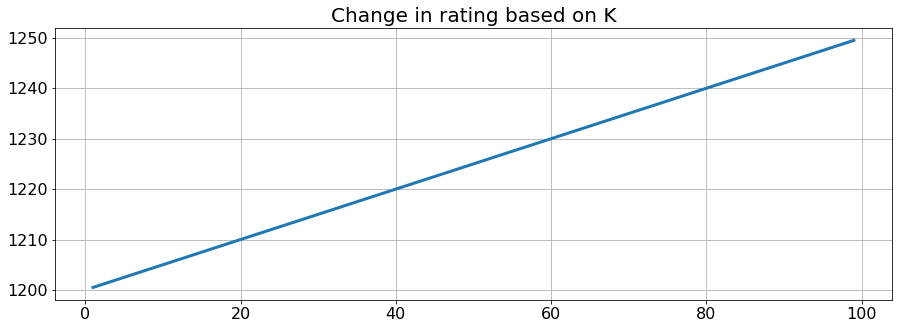

In [23]:
all_update = []
for K in range(1, 100):
    all_update.append(update(1200, 0.5, 1, K))
plt.plot(range(1, 100), all_update)
plt.title('Change in rating based on K'https://docs.google.com/presentation/d/1npolNV0f1Kz4YwQQjQeeKJw7RfNQEcJ5EkHx5Z1Lk0E/edit?usp=sharing)

In [14]:
def rate_elo(n=400, k=10, init_rating=1200):
    # set up rating lookup
    ratings = dict()
    for t in all_teams:
        ratings[t] = {'date': [], 'rating': []}
    # iterate over dataframe and assign ratings
    for row in df.itertuples():
        loser = row.loser
        winner = row.winner
        date = row.Date
        # use default rating if the team shows up for the first time
        try:
            old_rating_winner = ratings[winner]['rating'][-1]
        except IndexError:
            old_rating_winner = init_rating
        try:
            old_rating_loser = ratings[loser]['rating'][-1]
        except IndexError:
            old_rating_loser = init_rating
        exp_winner = expected(old_rating_winner, old_rating_loser, n)
        exp_loser = expected(old_rating_loser, old_rating_winner, n)
        if row.draw:
            rating_winner = update(old_rating_winner, exp_winner, 0.5, k)
            rating_loser = update(old_rating_loser, exp_loser, 0.5, k)
        else:
            rating_winner = update(old_rating_winner, exp_winner, 1, k)
            rating_loser = update(old_rating_loser, exp_loser, 0, k)
        ratings[winner]['rating'].append(rating_winner)
        ratings[winner]['date'].append(date)        
        ratings[loser]['rating'].append(rating_loser)
        ratings[loser]['date'].append(date)
    return ratings

In [10]:
ratings = rate_elo()

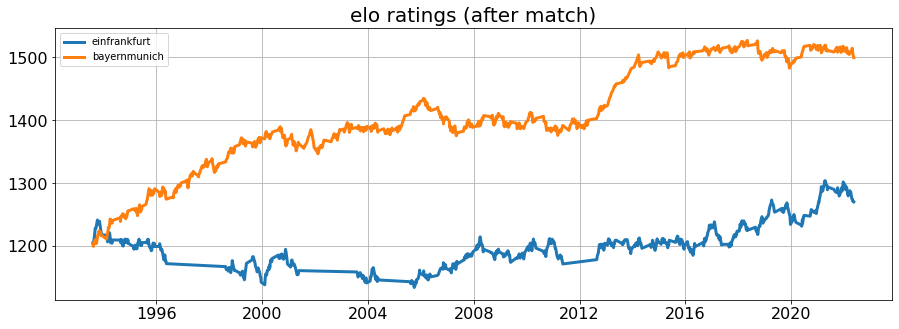

In [15]:
# plotting time: let's look at some teams over time!
team1 = 'einfrankfurt'
team2 = 'bayernmunich'
ratings = rate_elo(n=400, k=10, init_rating=1200)
fig, ax = plt.subplots()
plt.plot(ratings[team1]['date'], ratings[team1]['rating'], label=team1)
plt.plot(ratings[team2]['date'], ratings[team2]['rating'], label=team2)
plt.legend()
_ = plt.title('elo ratings (after match)')

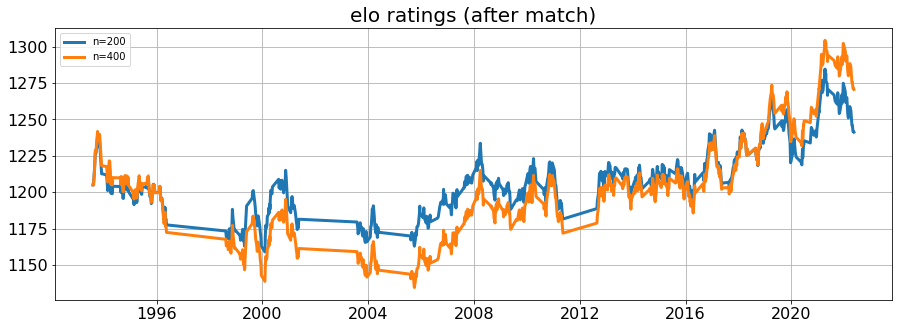

In [18]:
# plotting time: let's look at some teams over time!
team1 = 'einfrankfurt'
ratings1 = rate_elo(n=200, k=10, init_rating=1200)
ratings2 = rate_elo(n=400, k=10, init_rating=1200)
fig, ax = plt.subplots()
plt.plot(ratings1[team1]['date'], ratings1[team1]['rating'], label='n=200')
plt.plot(ratings2[team1]['date'], ratings2[team1]['rating'], label='n=400')
plt.legend()
_ = plt.title('elo ratings (after match)')

## Testing Elo quality

- We don't need a test set
- Careful about calibration time

Brier score:

$$BS = \frac{1} {N} \sum_{i=1}^N(E_i-S_i)^2$$

In [30]:
# write a function for the brier score

# could also use the one in sklearn.metrics
def brier_score(preds: list, outs: list) -> float:
    return 1 / len(preds) * sum([(i - j)**2 for i, j in zip(preds, outs)])

In [25]:
def get_rating_on_date(rating_dict, team, date, init_rating=1200):
    # todo: how do we manage ratings during calibration period?
    # since we stored the ratings AFTER the match, we always need to use the one before that day
    date_idx = rating_dict[team]['date'].index(date)
    if date_idx >= 1:
        return rating_dict[team]['rating'][date_idx - 1]
    else:
        return init_rating

In [26]:
elo_predictions = []
for winner, loser, date in zip(df.winner.values, df.loser.values, df.Date.values):
    winner_rating = get_rating_on_date(ratings, winner, date)
    loser_rating = get_rating_on_date(ratings, loser, date)
    elo_predictions.append(expected(winner_rating, loser_rating, n=400))

In [31]:
brier_score(elo_predictions, np.ones(len(elo_predictions))-0.5*df.draw)

0.1723160675153702

In [ ]:
# tuning time!